<a href="https://colab.research.google.com/github/mrefugionv/S14--TELECOMUNICACIONES/blob/main/P14_PROYECTO_FINAL_TELECOMUNICACION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final: Telecomunicaciones - Identificar operadores ineficientes
María del Refugio Noriega Vargas

## Definir objetivo

### ¿Qué se quiere conseguir y por qué?

Identificar a los operadores menos eficaces mediante los siguientes indicadores:
- La cantidad de llamadas entrantes perdidas (internas y externas).
- El tiempo de espera a las llamadas entrantes.
- Cantidad de llamadas salientes.

### ¿A quién le interesa este análisis?

A los y las supervisores de los operadores del servicio de telefónica virtual CallMeMaybe.

### ¿Qué decisiones se tomarán de acuerdo al análisis?

Decisiones sobre las medidas a implementar para la mejora del desempeño de los operadores.

## Proponer hipótesis

Un operador es de bajo desempeño si la cantidad de llamadas entrantes perdidas es elevado, el tiempo de espera de las llamadas entrantes es elevado y la cantidad de llamadas salientes es bajo.

## Preprocesamiento de datos

### Importación de librerías

In [ ]:
import pandas as pd               # Manejo de DataFrames y Series
import matplotlib.pyplot as plt   #Graficar
import datetime as dt             # Manejo de fechas
from dateutil import tz           # Uso de zonas horarias
import numpy as np                # Matrices
import seaborn as sns             # Gráfico de caja-bigotes & heatmap
import scipy.stats as stats       # Métodos estadísticos

### Importación de datos

In [ ]:
data = pd.read_csv('datasets/telecom_dataset_us.csv')
clients = pd.read_csv('datasets/telecom_clients_us.csv')

### Estudiar características generales.

#### Data

El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

In [ ]:
print(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


#### Clients

El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

In [ ]:
print(clients.info())
display(clients.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


### Renombrar columnas.

In [ ]:
def col_name_snakecase(data):
    """
    Función que toma un dataframe y
    transforma el nombre de sus columnas a snake_case
    """
    new_col_names =[]

    for old_name in data.columns:
        name_stripped = old_name.strip()
        name_lowered = name_stripped.lower()
        name_no_spaces = name_lowered.replace(' ','_')
        new_col_names.append(name_no_spaces)

    data.columns = new_col_names
    return(data)

### Manejo de valores ausentes.

#### Data

La única columna no con valores ausentes es 'operator_id'. Tiene 45730 filas completas de 53902, lo que representa un 15% de datos auscentes.

Dado que el 'operator_id' es información clave para la obtención de las metricas de estudio y no podemos obtenerlo de algún otro campo de la base de datos, se eliminan las filas vacías.

In [ ]:
print(data['operator_id'].min())
print(data['operator_id'].max())

879896.0
973286.0


In [ ]:
#data.fillna(10000,inplace=True)
#display(data[data['operator_id']== 10000])

In [ ]:
data = data.dropna()
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 45670 entries, 1 to 53900
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              45670 non-null  int64  
 1   date                 45670 non-null  object 
 2   direction            45670 non-null  object 
 3   internal             45670 non-null  object 
 4   operator_id          45670 non-null  float64
 5   is_missed_call       45670 non-null  bool   
 6   calls_count          45670 non-null  int64  
 7   call_duration        45670 non-null  int64  
 8   total_call_duration  45670 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.2+ MB
None


#### Clients

Esta base de datos no presenta valores auscentes, todas las columnas tiene 732 datos.

### Conversión de tipos de datos.

#### Data

- `user_id`: de entero a string.
- `date`: de objeto a datetime, de datetime UTC+3:00  a  datetime UTC.
- `direction`: objeto .
- `internal`: de objeto a booleano.
- `operator_id`: de flotante a string.
- `is_missed_call`: booleano.
- `calls_count`: entero.
- `call_duration`: entero.
- `total_call_duration`: entero.

In [ ]:
data['user_id'] = data['user_id'].astype('string')

#Convierte la cadena a un objeto datetime, teniendo en cuenta la zona horaria
data['date'] = data['date'].map(lambda x: dt.datetime.fromisoformat(x))
#Como todos los datos se registraron una vez al día a la misma hora, decido solo conservar la fecha sin la hora
data['date'] = data['date'].map( lambda x: x.strftime("%Y-%m-%d"))


data['internal'] = data['internal'].astype('bool')

data['operator_id'] = data['operator_id'].astype('int')
data['operator_id'] = data['operator_id'].astype('string')

print(data.info())
display(data.head())


<class 'pandas.core.frame.DataFrame'>
Index: 45670 entries, 1 to 53900
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              45670 non-null  string
 1   date                 45670 non-null  object
 2   direction            45670 non-null  object
 3   internal             45670 non-null  bool  
 4   operator_id          45670 non-null  string
 5   is_missed_call       45670 non-null  bool  
 6   calls_count          45670 non-null  int64 
 7   call_duration        45670 non-null  int64 
 8   total_call_duration  45670 non-null  int64 
dtypes: bool(2), int64(3), object(2), string(2)
memory usage: 2.9+ MB
None


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1,166377,2019-08-05,out,True,880022,True,3,0,5
2,166377,2019-08-05,out,True,880020,True,1,0,1
3,166377,2019-08-05,out,True,880020,False,1,10,18
4,166377,2019-08-05,out,False,880022,True,3,0,25
5,166377,2019-08-05,out,False,880020,False,2,3,29


#### Clients

- `user_id`: entero a string.
- `tariff_plan`: objeto.
- `date_start`: objeto a datetime.

In [ ]:
clients['user_id'] = clients['user_id'].astype('string')

clients['date_start'] = clients['date_start'].astype('string')
clients['date_start'] = clients['date_start'].map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

print(clients.info())
display(clients.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    string        
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(1), string(1)
memory usage: 17.3+ KB
None


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


### Manejo de valores duplicados.

#### Data

Solo se considerarán duplicados si todas las en las más de una fila, TODOS los campos son iguales.

Se eliminaron las 4179 filas duplicadas, conservando sólo uno de los registros. Pasamos de tener 45670 a 41491 registros lo que respresento 9% de las filas. Habrá que comunicar al equipo de algún error en el sistema de registros de datos.

In [ ]:
##¿Hay filas duplicadas?
data[data.duplicated(keep=False)]

data.drop_duplicates(keep='first',inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41491 entries, 1 to 53899
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              41491 non-null  string
 1   date                 41491 non-null  object
 2   direction            41491 non-null  object
 3   internal             41491 non-null  bool  
 4   operator_id          41491 non-null  string
 5   is_missed_call       41491 non-null  bool  
 6   calls_count          41491 non-null  int64 
 7   call_duration        41491 non-null  int64 
 8   total_call_duration  41491 non-null  int64 
dtypes: bool(2), int64(3), object(2), string(2)
memory usage: 2.6+ MB


#### Clients

No se tiene filas duplicadas. Tenemos 732 usuarios únicos.

In [ ]:
##¿Hay filas duplicadas?
clients[clients.duplicated(keep=False)]

,user_id,tariff_plan,date_start


## Análisis exploratorio de datos.

### Cantidad de llamadas entrantes perdidas por operador en el periodo registrado(totales, internas y externas)

Durante el periodo 2019-08-01 al 2019-11-27:

De los 1092 operadores registrados en la base de datos, el 21% (239 operadores) tuvieron llamadas perdidas. Como se explica a continuación, el 96% de ellas fueron llamadas externas.

En total, se perdieron 239 llamadas. De las y los operadores que pierden llamadas, el 75% de ellos perdieron menos de 4 llamada al día. Aunque se tiene registrado operadores que pierden hasta 52 llamadas en este periodo. Se consideran atipicos los valores mayores a 4.

De las llamadas perdidas solo 20 fueron internas y se pierden en general 1 llamada, aunque tenemos un operador que perdío 2 de este tipos de llamadas. Se consideran valores atípicos los valores mayores a 1.

De las llamadas perdidas 231 fueron externas y en promedio cada operador, de los 239, perdío 3.9 llamadas externas este periodo, uno perdio 52.Se consideran atipicos los valores mayores a 4.





In [ ]:
calls_in = data[data['direction']=='in']
calls_in_lost_total = calls_in[calls_in['is_missed_call']==True]

print(f'Cantidad de opreadores únicos de registros:')
print(data['operator_id'].nunique())
print(f'Cantidad de días únicos de registros:')
print(data['date'].nunique())
print(data['date'].min())
print(data['date'].max())
print(f'Cantidad de opreadores únicos de registros de llamadas entrantes perdidas:')
print(calls_in_lost_total['operator_id'].nunique())
print(f'Cantidad de días únicos de registros de llamadas entrantes perdidas:')
print(calls_in_lost_total['date'].nunique())

#Llamadas entrantes perdidas por día por operador
total_calls_per_day_per_operator = calls_in_lost_total.groupby(['operator_id']).agg({'calls_count':'sum'}).reset_index()
#Por el tamaño del df (239 * 93) se decide no graficar heatmap
#pivot_total = calls_in_lost.pivot_table(index = 'operator_id',columns = 'date', values='calls_count',aggfunc='sum')
#sns.heatmap(data= pivot_total,annot=True, fmt=".1f" )

#Llamadas entranter INTERNAS perdidas por día por operador
calls_in_lost_internal = calls_in_lost_total[calls_in_lost_total['internal']==True]
internal_calls_per_day_per_operator = calls_in_lost_internal.groupby(['operator_id']).agg({'calls_count':'sum'}).reset_index()

#Llamadas entranter EXTERNAS perdidas por día por operador
calls_in_lost_external = calls_in_lost_total[calls_in_lost_total['internal']==False]
external_calls_per_day_per_operator = calls_in_lost_external.groupby(['operator_id']).agg({'calls_count':'sum'}).reset_index()
external_calls_per_day_per_operator.columns=['operator_id','calls_count_external']

df = pd.merge(total_calls_per_day_per_operator,internal_calls_per_day_per_operator, how='outer', on='operator_id',suffixes=('_total','_internal'))
df_lost_calls = pd.merge(df, external_calls_per_day_per_operator, how='outer', on='operator_id')
display(df_lost_calls)


Cantidad de opreadores únicos de registros:
1092
Cantidad de días únicos de registros:
118
2019-08-02
2019-11-28
Cantidad de opreadores únicos de registros de llamadas entrantes perdidas:
239
Cantidad de días únicos de registros de llamadas entrantes perdidas:
93


,operator_id,calls_count_total,calls_count_internal,calls_count_external
0,882680,3,NaN,3.0
1,882684,4,NaN,4.0
2,882686,6,NaN,6.0
3,882690,2,NaN,2.0
4,884408,4,1.0,3.0
...,...,...,...,...
234,959312,7,NaN,7.0
235,960620,1,NaN,1.0
236,964510,2,NaN,2.0
237,964666,3,NaN,3.0


,calls_count_total,operator_id
0,1,110
1,2,41
2,3,27
3,4,13
4,5,5
5,6,9
6,7,4
7,8,3
8,9,3
9,10,4


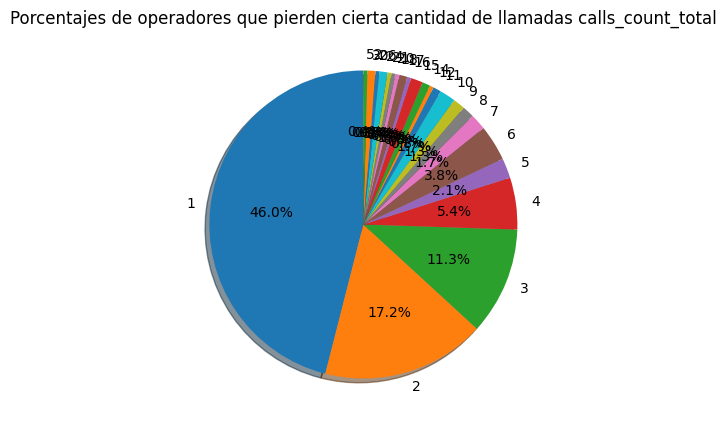

,calls_count_internal,operator_id
0,1.0,17
1,2.0,2
2,3.0,1


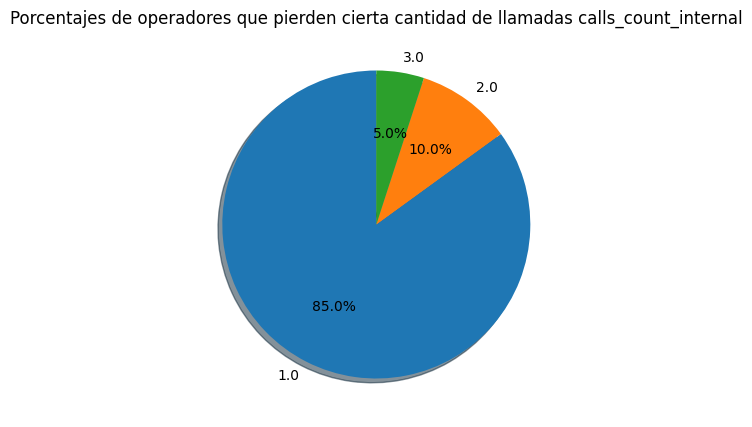

,calls_count_external,operator_id
0,1.0,107
1,2.0,38
2,3.0,27
3,4.0,12
4,5.0,7
5,6.0,6
6,7.0,4
7,8.0,4
8,9.0,2
9,10.0,4


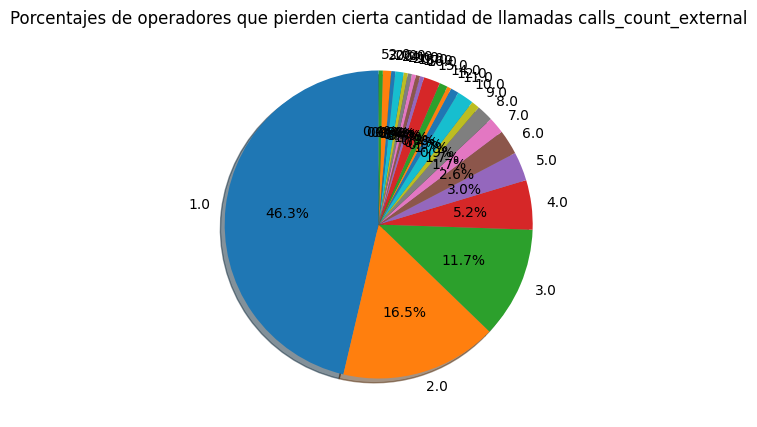

()

In [ ]:
def graph_metric(df,metric):
    """
    1.Esta función obtiene el dataframe con el conteo del parametro por operador,
    2. Agrupa por valor de metrica y cuenta cuantos operadores tuvieron ese valor de métrica.
    3. Genera un gráfico de pastel con el procentaje de operadores que tuvieron cierto valor en esa metrica
    """
    calls_pie = df.groupby([metric]).agg({'operator_id':'count'}).reset_index()
    display(calls_pie)

    plt.figure(figsize=(5, 5))
    plt.pie(calls_pie['operator_id'], labels= calls_pie[metric], autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title(f'Porcentajes de operadores que pierden cierta cantidad de llamadas {metric}')
    plt.show()

    return()

graph_metric(df_lost_calls,'calls_count_total')
graph_metric(df_lost_calls,'calls_count_internal')
graph_metric(df_lost_calls,'calls_count_external')


##### Manejo de valores atípicos.

El manejo de valores atípicos para las metricas de cantidades de llamadas entrantes perdidas (totales/internas/externas), se realiza para determinar en cuál es la cantidad "normal" que un operador pierde y cuésles con aquellos operadores ques están dejando ir demasiadas llamadas entrantes. Es necesario recordar que esta metricas se estan obteniendo sin considerar a los operadores que tuvieron una gran eficiencia y no tienen llamadas perdidas registradas.



##### Manejo de valores atípicos. Total llamadas entrantes perdidas.


       calls_count
count   239.000000
mean      3.870293
std       5.944060
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      52.000000


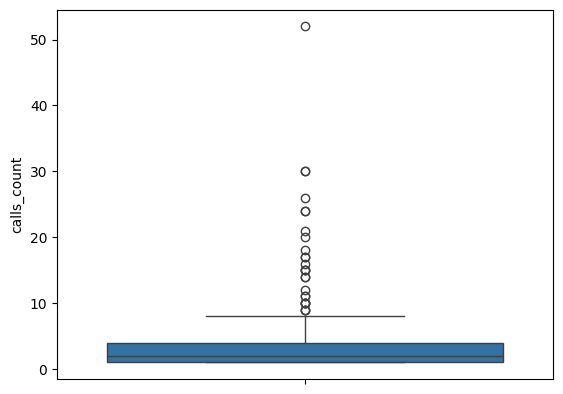

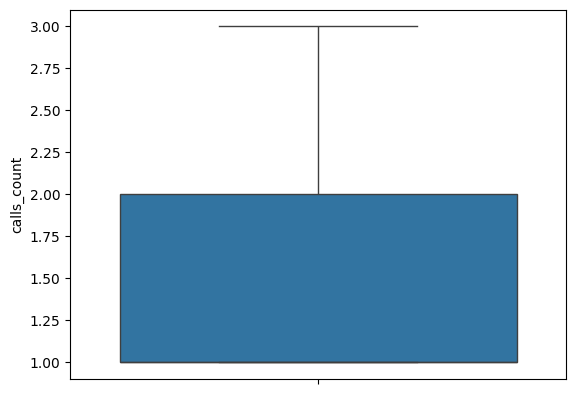

In [ ]:
print(total_calls_per_day_per_operator.describe())
sns.boxplot(total_calls_per_day_per_operator['calls_count'])
plt.show()
sns.boxplot(total_calls_per_day_per_operator[total_calls_per_day_per_operator['calls_count']<4]['calls_count'])
plt.show()

##### Manejo de valores atípicos. Llamadas entranter INTERNAS perdidas por día por operador.

count    20.000000
mean      1.200000
std       0.523148
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: calls_count, dtype: float64


<Axes: ylabel='calls_count'>

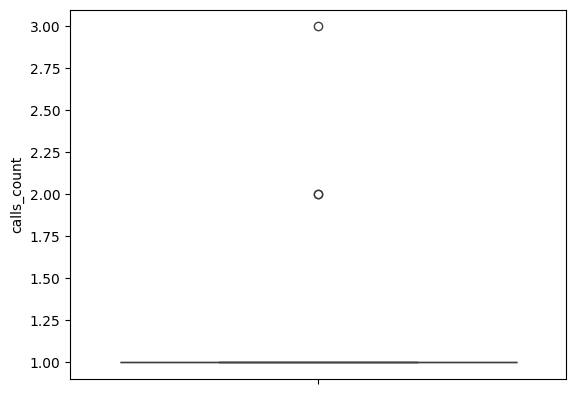

In [ ]:
print(internal_calls_per_day_per_operator['calls_count'].describe())
sns.boxplot(internal_calls_per_day_per_operator['calls_count'])

##### Manejo de valores atípicos. Llamadas perdidas EXTERNAS por día por operador.

count    231.000000
mean       3.900433
std        6.008946
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       52.000000
Name: calls_count_external, dtype: float64


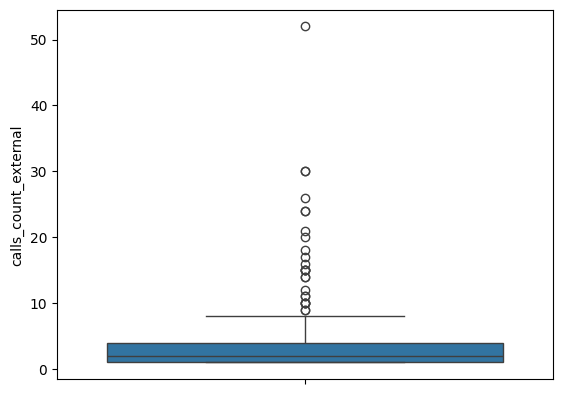

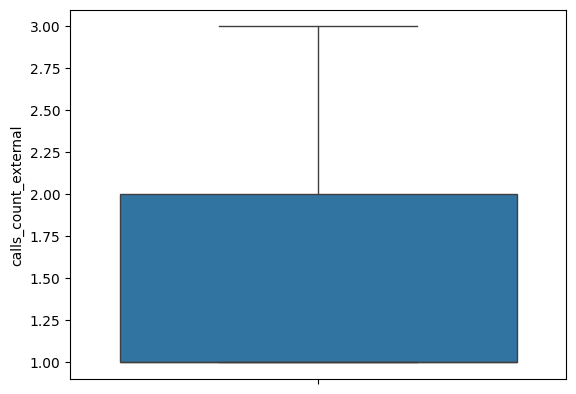

In [ ]:
print(external_calls_per_day_per_operator['calls_count_external'].describe())
sns.boxplot(external_calls_per_day_per_operator['calls_count_external'])
plt.show()
sns.boxplot(external_calls_per_day_per_operator[external_calls_per_day_per_operator['calls_count_external']<4]['calls_count_external'])
plt.show()

### Tiempo de espera promedio para llamadas entrantes por operador en el periodo de tiempo registrado en la base de datos.

Durante el periodo 2019-08-01 al 2019-11-27, los 754 operadores tuvieron tiempos promedios de espera desde los 1 unidad de tiempo hasta los 1,007. El 75% de los operadores tienen tiempos de espera menores a los 58 unidades de tiempo. Se consideran atipicos los valores mayores a 86. Eliminando los valores atípicos el 75% de los operadores tiene un tiempo de espera promedio de 44 segundos.

In [ ]:
data['waiting_time'] = data['total_call_duration'] - data['call_duration']
calls_in = data[data['direction']=='in']
waiting_time_mean = calls_in.groupby(['operator_id']).agg({'waiting_time':'mean'}).reset_index()
display(waiting_time_mean)
print(int(waiting_time_mean['waiting_time'].min()))
print(int(waiting_time_mean['waiting_time'].max()))

,operator_id,waiting_time
0,879896,27.333333
1,879898,29.875000
2,880020,7.714286
3,880022,14.000000
4,880026,7.944444
...,...,...
749,971102,338.000000
750,971354,42.000000
751,972412,25.000000
752,972460,4.000000


1
1007


#### Gráfica de barras

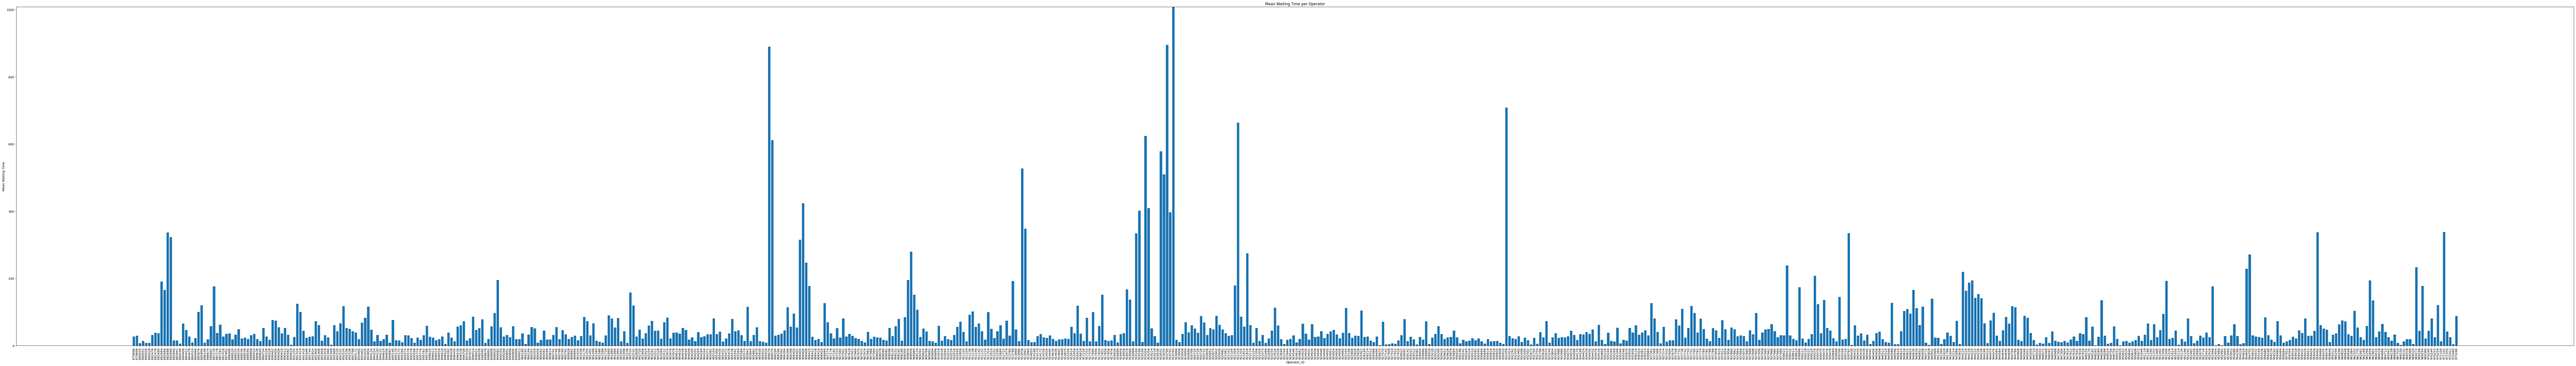

In [ ]:
plt.figure(figsize=(150, 20))
plt.bar(waiting_time_mean['operator_id'], waiting_time_mean['waiting_time'])
plt.xlabel('Operator_ID')
plt.ylabel('Mean Waiting Time')
plt.title('Mean Waiting Time per Operator')
plt.ylim(0,1008)
plt.xticks(rotation='vertical')
plt.show()

,waiting_time_group,operator_id
0,1.0,666
1,2.0,57
2,3.0,9
3,4.0,9
4,5.0,3
5,6.0,3
6,7.0,3
7,8.0,1
8,9.0,2
9,11.0,1


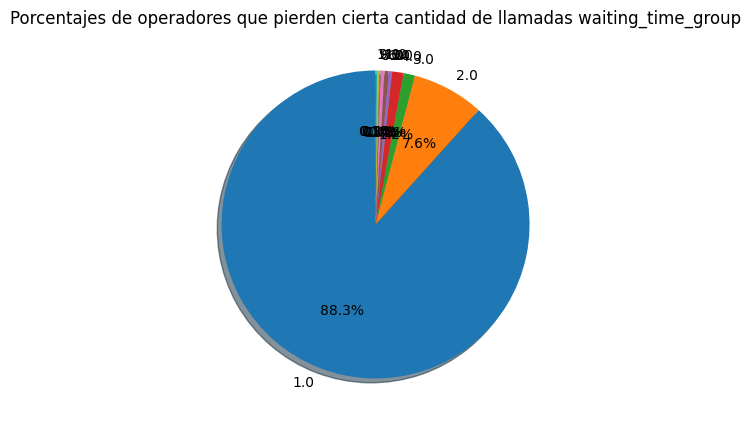

()

In [ ]:
for i in range(0,754):
    time = int(waiting_time_mean.loc[i,'waiting_time'])
    if  time > 1000 :
        waiting_time_mean.loc[i,'waiting_time_group']  = 11
    elif time > 900 :
        waiting_time_mean.loc[i,'waiting_time_group']  = 10
    elif time > 800 :
        waiting_time_mean.loc[i,'waiting_time_group']  = 9
    elif time > 700 :
        waiting_time_mean.loc[i,'waiting_time_group'] = 8
    elif time > 600 :
        waiting_time_mean.loc[i,'waiting_time_group']  = 7
    elif time  > 500 :
        waiting_time_mean.loc[i,'waiting_time_group']  = 6
    elif time  > 400 :
        waiting_time_mean.loc[i,'waiting_time_group'] = 5
    elif time  > 300 :
        waiting_time_mean.loc[i,'waiting_time_group']  = 4
    elif time  > 200 :
        waiting_time_mean.loc[i,'waiting_time_group']  = 3
    elif time  > 100 :
        waiting_time_mean.loc[i,'waiting_time_group']  = 2
    else:
        waiting_time_mean.loc[i,'waiting_time_group']  = 1


graph_metric(waiting_time_mean,'waiting_time_group')

#### Manejo de valores atípicos.

En este caso se busca que los operadores tenga bajos tiempos de espera, lo que nos indican los valores atípicos son aquellos operadores que tienen tiempos de espera mucho mayores a la media. Hay que eliminar los outliers para poder calculas una media de tiempo de espera más representativo a la mayoria de los operadores. Y así delimitar cual es lo promedio de la mayoria de los operadores. Al igual que en las métricas anteriores, considerar que estos parámetros se estan obteniendo sin considerar a los operadores que tuvieron un excelente performace y su tiempo de espera promedio fue menor a 1.

count     754.000000
mean       58.078640
std        96.517905
min         1.000000
25%        17.500000
50%        31.000000
75%        58.000000
max      1007.375000
Name: waiting_time, dtype: float64


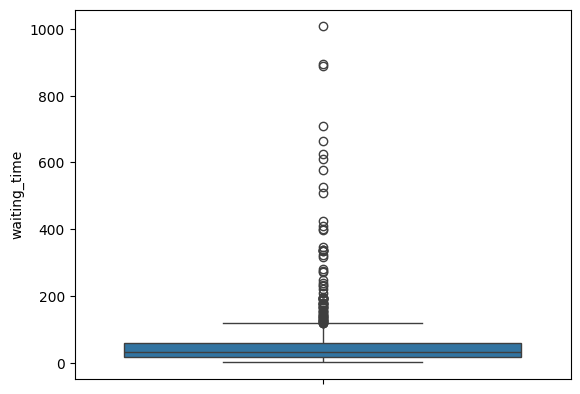

count    648.000000
mean      31.601867
std       20.191711
min        1.000000
25%       15.764423
50%       27.333333
75%       44.000000
max       85.761905
Name: waiting_time, dtype: float64


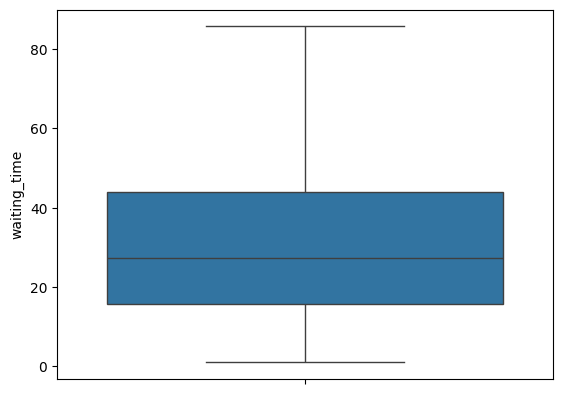

In [ ]:
print(waiting_time_mean['waiting_time'].describe())
sns.boxplot(waiting_time_mean['waiting_time'])
plt.show()
print(waiting_time_mean[waiting_time_mean['waiting_time'] <86]['waiting_time'].describe())
sns.boxplot(waiting_time_mean[waiting_time_mean['waiting_time'] <86]['waiting_time'])
plt.show()

### Cantidad de llamadas salientes promedio  para cada operador en el periodo de tiempo registrado en la base de datos.

Tenemos 882 operadores que realizaron entre 1 y 58977 llamadas durante el periodo, el resto de los 1092 operadores , no realizo llamadas. El 75% de los operadores realizan menos de 597 llamadas por lo que es limite que se utiliza para eliminar los valores atípicos, es decir operadores con muy buen performance. Por lo que se eliminan estos valores para sacar el promedio de llamadas que deberían estar realizando los operadores, que es de 101 llamadas. Recordar que no se han considerado los operadores que no realizaron llamadas para sacar el promedio.

In [ ]:
out_calls = data[data['direction']=='out']
out_calls_per_operator= out_calls.groupby(['operator_id']).agg({'calls_count':'sum'}).reset_index()
display(out_calls_per_operator)
print(out_calls_per_operator['calls_count'].min())
print(out_calls_per_operator['calls_count'].max())

,operator_id,calls_count
0,879896,872
1,879898,7209
2,880020,38
3,880022,189
4,880026,2208
...,...,...
877,972408,6
878,972410,77
879,972412,60
880,972460,50


1
58977


#### Gráfica de barras.

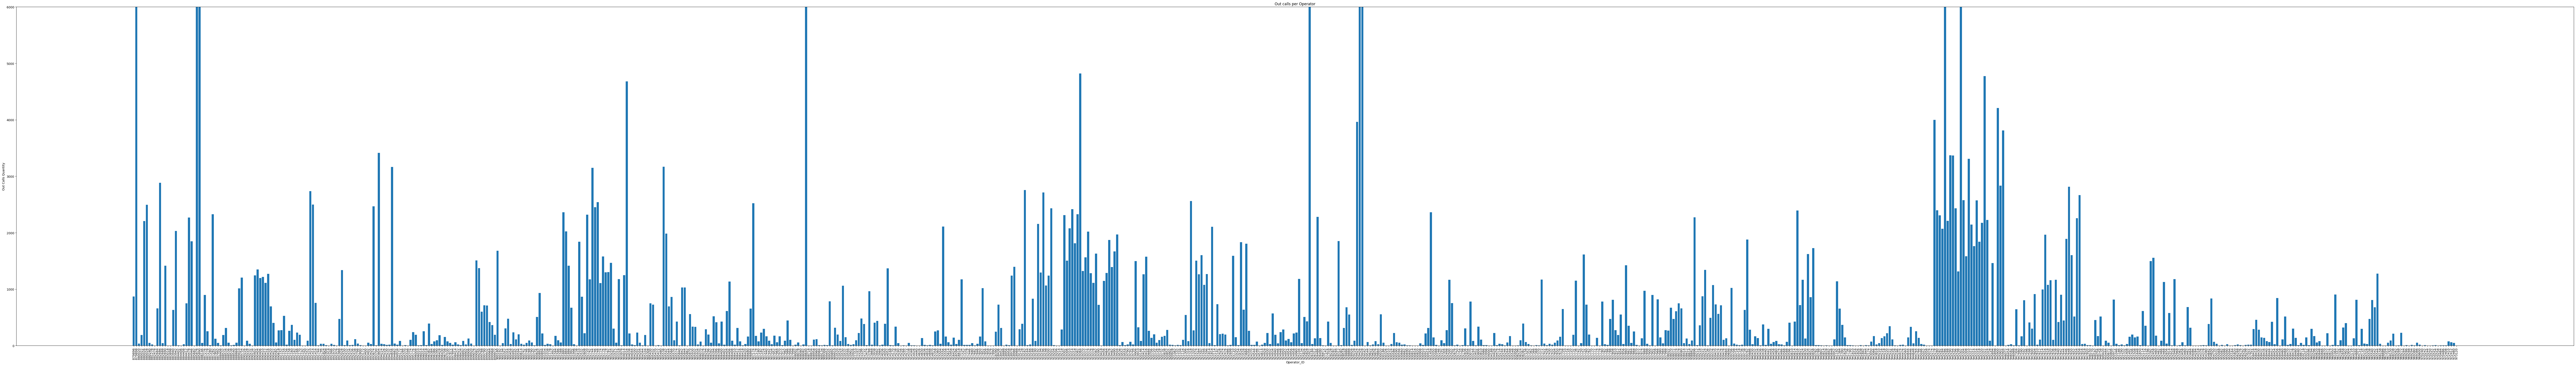

In [ ]:
plt.figure(figsize=(150, 20))
plt.bar(out_calls_per_operator['operator_id'], out_calls_per_operator['calls_count'])
plt.xlabel('Operator_ID')
plt.ylabel('Out Calls Quantity')
plt.title('Out calls per Operator')
plt.ylim(0,6000)
plt.xticks(rotation='vertical')
plt.show()

,calls_count_group,operator_id
0,1.0,722
1,2.0,154
2,3.0,3
3,4.0,1
4,7.0,2


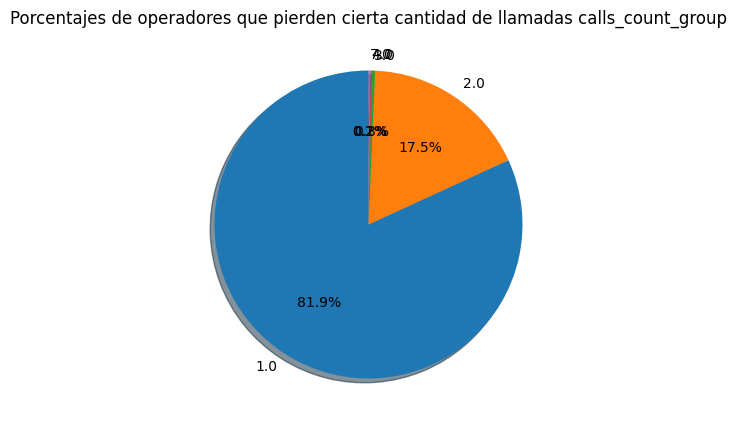

()

In [ ]:
for i in range(0,882):
    calls = int(out_calls_per_operator.loc[i,'calls_count'])
    if  calls > 60000 :
        out_calls_per_operator.loc[i,'calls_count_group']  = 8
    elif calls > 50000 :
        out_calls_per_operator.loc[i,'calls_count_group']  = 7
    elif calls > 40000 :
        out_calls_per_operator.loc[i,'calls_count_group'] = 6
    elif calls > 30000 :
        out_calls_per_operator.loc[i,'calls_count_group'] = 5
    elif calls > 20000 :
        out_calls_per_operator.loc[i,'calls_count_group']  = 4
    elif calls  > 10000 :
        out_calls_per_operator.loc[i,'calls_count_group']  = 3
    elif calls  > 1000 :
        out_calls_per_operator.loc[i,'calls_count_group']  = 2
    else:
        out_calls_per_operator.loc[i,'calls_count_group']  = 1

graph_metric(out_calls_per_operator,'calls_count_group')

#### Manejo de valores atípicos.

En este caso los se pretende que los operadores realizen la mayor cantidad de llamadas por lo que los valores, atípicos son aquellos operadores que realizaron muchas más llamadas que los demás. Hay que eliminarlos para poder obtener un promedio que represente a la mayoría de los operadores, que esta en menos de 1000 llamadas y tenemos 5 operadores que realizaron hasta 50,000.

count      882.000000
mean       689.731293
std       3122.953946
min          1.000000
25%         11.000000
50%         90.000000
75%        597.250000
max      58977.000000
Name: calls_count, dtype: float64


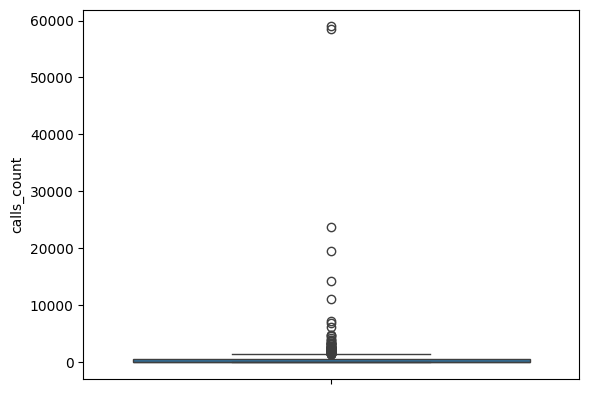

count    661.000000
mean     101.075643
std      136.655640
min        1.000000
25%        7.000000
50%       33.000000
75%      148.000000
max      580.000000
Name: calls_count, dtype: float64


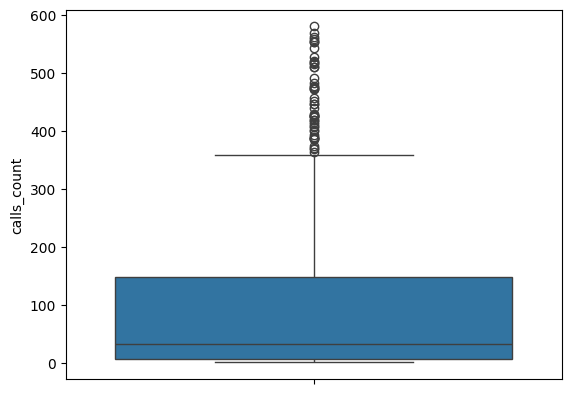

In [ ]:
print(out_calls_per_operator['calls_count'].describe())
sns.boxplot(out_calls_per_operator['calls_count'])
plt.show()
print(out_calls_per_operator[out_calls_per_operator['calls_count'] <600]['calls_count'].describe())
sns.boxplot(out_calls_per_operator[out_calls_per_operator['calls_count'] <600]['calls_count'])
plt.show()

## Procesamiento de datos

### Determinar valores límites de cada métrica para determinar si un operador es de bajo desempeño.

De acuerdo a lo revisado anteriormente, los valores va para los operadores de bajo desempeño que se proponen son:
- La cantidad de llamadas entrantes perdidas totales mayor a 4.
- La cantidad de llamadas entrantes perdidas internas mayor a 1.
- La cantidad de llamadas entrantes perdidas externas mayor a 4.
- El tiempo de espera a las llamadas entrantes mayor a 44 unidades de tiempo.
- Cantidad de llamadas salientes menor a 101.

In [ ]:
# Se Obtiene el dataframe completo de todos los operadores registrados con sus metricas correspodientes

df_1 = pd.merge(df_lost_calls, waiting_time_mean, how='outer', on='operator_id')
df_2 = pd.merge(df_1, out_calls_per_operator, how='outer', on='operator_id',suffixes = ('','_out'))
all_operators = pd.DataFrame(data['operator_id'].unique())
all_operators.columns = ['operator_id']
all_operators_info = pd.merge(all_operators, df_2, how='outer', on='operator_id')
all_operators_info.fillna(value=0, inplace=True)
display(all_operators_info)


,operator_id,calls_count_total,calls_count_internal,calls_count_external,waiting_time,waiting_time_group,calls_count,calls_count_group
0,879896,0.0,0.0,0.0,27.333333,1.0,872.0,1.0
1,879898,0.0,0.0,0.0,29.875000,1.0,7209.0,2.0
2,880020,0.0,0.0,0.0,7.714286,1.0,38.0,1.0
3,880022,0.0,0.0,0.0,14.000000,1.0,189.0,1.0
4,880026,0.0,0.0,0.0,7.944444,1.0,2208.0,2.0
...,...,...,...,...,...,...,...,...
1087,972410,0.0,0.0,0.0,0.000000,0.0,77.0,1.0
1088,972412,0.0,0.0,0.0,25.000000,1.0,60.0,1.0
1089,972460,0.0,0.0,0.0,4.000000,1.0,50.0,1.0
1090,973120,0.0,0.0,0.0,0.000000,0.0,3.0,1.0


### Pruebas estadísticas entre operadores eficientes y no eficientes.

Se aplica pruebas estadísticas de t-student(compara dos poblaciones: los operadores de buen desempempeno y los de baja eficiencia), de una cola para revisar si los valores seleccionados son signifcativos.

Hipotesis Nula (H0):
Para los operadores eficientes y no eficientes...
-  La cantidad de llamadas entrantes perdidas son iguales.
- La cantidad de llamadas entrantes internas perdidas son iguales.
- La cantidad de llamadas entrantes externas perdidas son iguales.
- El tiempo de espera a las llamadas son iguales.
- Cantidad de llamadas salientes son iguales.

Hipotesis Nula (H1):
Para los operadores  no eficientes...
-  La cantidad de llamadas entrantes perdidas es mayor.
- La cantidad de llamadas entrantes internas perdidas es mayor.
- La cantidad de llamadas entrantes externas perdidas es mayor.
- El tiempo de espera a las llamadas es menor.
- Cantidad de llamadas salientes es menor.



In [ ]:
def prueba_tstudent_1cola( df,column,valor,limite_atipico,mayor_menor):

    """
    Funcion que:
    1. Filtra la serie de datos de acuerdo al valor limite de atípicos y
    la indicación "menor o mayor"
    2. Obtiene los dos grupos de acuerdo al valor que se propuso para diferenciar a
    los operadores eficientes y no eficientes
    3. se realiza prueba de levene para determinar si varianzas entre
    grupos son iguales, si p-value > alpha entonces equal_var = False
    3. Realiza la prueba t-student para dos poblaciones.
    4. Realiza prueba de hipótesis de 1 cola.
    """
    if mayor_menor == 'mayor':
        df_filtered = df[df[column]<= limite_atipico]
    elif  mayor_menor == 'menor':
        df_filtered = df[df[column]>= limite_atipico]

    group_1 = df_filtered[df_filtered[column]> valor]
    group_2 = df_filtered[df_filtered[column]<= valor]

    alpha = 0.05

    #Prueba de levene para deternimar si varianzas entre grupos son iguales.
    # si p_value de levene > alpha varianzas son diferentes y se asigna equal_var= False...
    #.. ya que no se puede asegurar que las metricas son iguales entre los grupos.
    levene = stats.levene(group_1[column], group_2[column])

    if levene[1] > alpha:
        results = stats.ttest_ind(group_1[column], group_2[column], equal_var = False)
    else:
        results = stats.ttest_ind(group_1[column], group_2[column], equal_var = True)

    #Hipótesis nula de 1 colas:
    print(f'Resultados de la metrica {column}')
    if ((results[1] / 2) < alpha) and (group_1[column].mean() > group_2[column].mean()):
        print("Rechazamos hipótesis nula")
    else:
        print("No hay motivos suficientes para rechazar hipótesis nula")

    return()

prueba_tstudent_1cola(all_operators_info,'calls_count_total',4,0,'menor')
prueba_tstudent_1cola(all_operators_info,'calls_count_internal',1,0,'menor')
prueba_tstudent_1cola(all_operators_info,'calls_count_external',4,0,'menor')
prueba_tstudent_1cola(all_operators_info,'waiting_time',44,86,'mayor')
prueba_tstudent_1cola(all_operators_info,'calls_count',101,660,'mayor')



Resultados de la metrica calls_count_total
Rechazamos hipótesis nula
Resultados de la metrica calls_count_internal
Rechazamos hipótesis nula
Resultados de la metrica calls_count_external
Rechazamos hipótesis nula
Resultados de la metrica waiting_time
Rechazamos hipótesis nula
Resultados de la metrica calls_count
Rechazamos hipótesis nula


()

## Lista de operadores de baja eficiencia, de acuerdo a métricas estudiadas

In [ ]:
def low_eficiency( df,column,value,greater_less):
    """
    Funcion que:
    1. Filtra los identificadores de los operadores de acuerdo al valor
    al valor de la metrica indicadas
    """
    print(f'Operadores poco eficientes de acuerdo a las metrica {column}')
    if greater_less == 'mayor':
        low_eficiency_operators = df[df[column]> value]['operator_id']
        low_eficiency_operators = pd.DataFrame(low_eficiency_operators).reset_index()
        display(low_eficiency_operators)
    elif  greater_less == 'menor':
        low_eficiency_operators = df[df[column]< value]['operator_id']
        low_eficiency_operators = pd.DataFrame(low_eficiency_operators).reset_index()
        display(low_eficiency_operators)

    return()

low_eficiency_total_lost_calls = low_eficiency( all_operators_info,'calls_count_total',4,'mayor')
low_eficiency_internal_lost_calls = low_eficiency( all_operators_info,'calls_count_internal',1,'mayor')
low_eficiency_external_lost_calls = low_eficiency( all_operators_info,'calls_count_external',4,'mayor')
low_eficiency_waiting_time = low_eficiency( all_operators_info,'waiting_time',44,'mayor')
low_eficiency_calls_out = low_eficiency( all_operators_info,'calls_count',101,'menor')


Operadores poco eficientes de acuerdo a las metrica calls_count_total


,index,operator_id
0,12,882686
1,28,885876
2,29,885890
3,108,893804
4,162,899250
5,203,901880
6,245,905104
7,246,905300
8,263,905862
9,272,906392


Operadores poco eficientes de acuerdo a las metrica calls_count_internal


,index,operator_id
0,652,934534
1,785,940624
2,786,940630


Operadores poco eficientes de acuerdo a las metrica calls_count_external


,index,operator_id
0,12,882686
1,28,885876
2,29,885890
3,108,893804
4,162,899250
5,203,901880
6,245,905104
7,246,905300
8,263,905862
9,272,906392


Operadores poco eficientes de acuerdo a las metrica waiting_time


,index,operator_id
0,11,882684
1,12,882686
2,13,882688
3,14,882690
4,22,884408
...,...,...
261,1070,969294
262,1076,970244
263,1079,970254
264,1084,971102


Operadores poco eficientes de acuerdo a las metrica calls_count


,index,operator_id
0,2,880020
1,6,880240
2,7,881278
3,8,882476
4,9,882478
...,...,...
658,1087,972410
659,1088,972412
660,1089,972460
661,1090,973120


Analizando los resultados sobre los operadores menos eficientes se pueden identificar las isguientes razones y consideraciones:
- La cantidad de llamadas entrantes perdidas (totales/internas/externas).
-
Se obtienen 48 operadores con más de 4 llamadas perdidas durante el periodo, las 4 llamadas perdidas es el limite dentro del cual el 75% de los operadores que perdieron llamadas (21% de los operadores totales) por lo que en realidad la mayor parte de los operadores no tienen llamadas perdidas. Las perdidas de llamadas son ocasionales.
En cuanto a las llamadas perdidas solo un pequeño porcentaje son internas.

- El tiempo de espera a las llamadas entrantes es mayor a 44 unidades de tiempo.
  
Este limite se obtuvo calculando donde se encontraban el 75% de los operadores que tuvieron tiempos de espera promedio mayores a 1, eliminando los valores atípicos que recorrían ese número haciendolo una cantidad mayor. Recordar que de los 1092 operadores el 754 (30%) tuvieron tiempos de espera promedio menores a 1 unidad de tiempo.

- Cantidad de llamadas salientes es menor a 101.
  
Es el  valor promedio de llamadas que realizan los operadores (eliminando aquellos que no realizaron llamadas y los 5 valores atípicos que excedieron por mucho el comportamiento general). En este parámetro hay que poner mayor atención a los 210 (19%) de los operadores que no realizaron ninguna llamada durante el periodo.

## Conclusiones y recomendaciones

Dado que las pruebas de hipótesis resultaron en rechazar las hipotesis nulas, quiere decir que se obtuvieron los valores de las métricas en las culaes los grupos de los operadores eficientes y no eficientes pueden ser diferenciados con un valor de alpha (precisión) de 5% .
Esos valores son, para identificar a los operadores menos eficientes:
- La cantidad de llamadas entrantes perdidas totales es mayor a 4.
- La cantidad de llamadas entrantes perdidas internas es mayor a 1.
- La cantidad de llamadas entrantes perdidas externas es  mayor a 4.
- El tiempo de espera a las llamadas entrantes es mayor a 44 unidades de tiempo.
- Cantidad de llamadas salientes es menor a 101.

Se recomienda combinar varios parámetros para tomar decisiones. Además de felicitar a aquello valores atípicos, por ejemplo los operadores que hicieron gran tantidad de llamadas o aquellos que tuvieron tiempos de espera más cortos a la media.

## Anexos

### Enlace a Dashboard (Tableu Public)

https://public.tableau.com/views/ProyectoTelecomunicaciones_17489125856570/Dashboard1?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

### Presentación

https://docs.google.com/presentation/d/14mfaMj-eHW-aFPJL_5HpaEOgMGW5sz_mAkobtUlYosw/edit?usp=sharing

## Fuentes / Documentación consultada

* Manejo de datos datetime con zona horaria:  https://docs.python.org/es/3.9/library/datetime.html
* Método merge de pandas: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
* Graficas pyplot: https://matplotlib.org/stable/tutorials/pyplot.html
* Grafica caja-bigotes, seaborn: https://seaborn.pydata.org/generated/seaborn.boxplot.html
* Prueba T-Student: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
* Prueba de Levene: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html